In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def f(staked_amt, target_amt, sigma=0.02):
    return np.exp(- (staked_amt - target_amt)**2 / (2 * sigma**2))

def simulate_apy(
    total_supply=2_000_000_000, 
    staking_reward_amt=600_000_000, 
    staking_reward_timeline_yrs=10, 
    rng = None,
    stake_pct_trajectory_mean = 0.2,
    stake_pct_trajectory_std = 0.03,
):
    
    if rng is None:
        rng = np.random.RandomState(42)

    yearly_nominal_release=staking_reward_amt / staking_reward_timeline_yrs
    validator_reward_pot=yearly_nominal_release
    airdrop_by_year=staking_reward_timeline_yrs*[1_000_000]
    cs_pct_by_yr=[0.30, 0.47, 0.62, 0.75, 0.80, 1, 1, 1, 1, 1]
    target_lock_pct_by_yr = 10*[0.2]
    sigma_by_yr = 10*[0.05]
    max_apy = 0.5

    apy_with_airdrop_yr = []
    apy_without_airdrop_yr = []
    staked_pct_by_yr = []
    validator_reward_pot_by_yr = []
    validator_rewards_distributed_by_yr = []
    for yr in range(1,10+1):
        cs_nominal = total_supply * cs_pct_by_yr[yr-1]
        target_stake_pct = target_lock_pct_by_yr[yr-1]
        f_sigma = sigma_by_yr[yr-1]

        stake_pct = rng.normal(loc=stake_pct_trajectory_mean, scale=stake_pct_trajectory_std)
        staked_amt = cs_nominal * stake_pct
        
        release_pct = f(stake_pct, target_stake_pct, sigma=f_sigma)
        remaining_pct = 1-release_pct
        validator_rewards_release_amt = release_pct * validator_reward_pot
        validator_reward_pot = (remaining_pct * validator_reward_pot) + yearly_nominal_release
        
        # Calculate APY without airdrop first
        apy_without_airdrop = validator_rewards_release_amt / staked_amt
        
        # If APY exceeds max_apy, adjust the release amount
        if apy_without_airdrop > max_apy:
            # Calculate how much we actually need to release to hit max_apy
            actual_release_amt = staked_amt * max_apy
            # Add the excess back to the pot
            validator_reward_pot += (validator_rewards_release_amt - actual_release_amt)
            validator_rewards_release_amt = actual_release_amt
            apy_without_airdrop = max_apy
        
        release_with_airdrop = validator_rewards_release_amt + airdrop_by_year[yr-1]
        apy_with_airdrop = release_with_airdrop / staked_amt

        validator_reward_pot_by_yr.append(validator_reward_pot)
        staked_pct_by_yr.append(stake_pct)
        apy_with_airdrop_yr.append(apy_with_airdrop)
        apy_without_airdrop_yr.append(apy_without_airdrop)
        validator_rewards_distributed_by_yr.append(validator_rewards_release_amt)
    return {
        "apy_with_airdrop_yr": np.array(apy_with_airdrop_yr),
        "apy_without_airdrop_yr": np.array(apy_without_airdrop_yr),
        "staked_pct_by_yr": np.array(staked_pct_by_yr),
        'target_lock_pct_by_yr': np.array(target_lock_pct_by_yr),
        'validator_reward_pot_by_yr': np.array(validator_reward_pot_by_yr),
        'validator_rewards_distributed_by_yr': np.array(validator_rewards_distributed_by_yr),
    }

In [4]:
results = simulate_apy(
    stake_pct_trajectory_mean=0.15,
    stake_pct_trajectory_std=0.00,
)

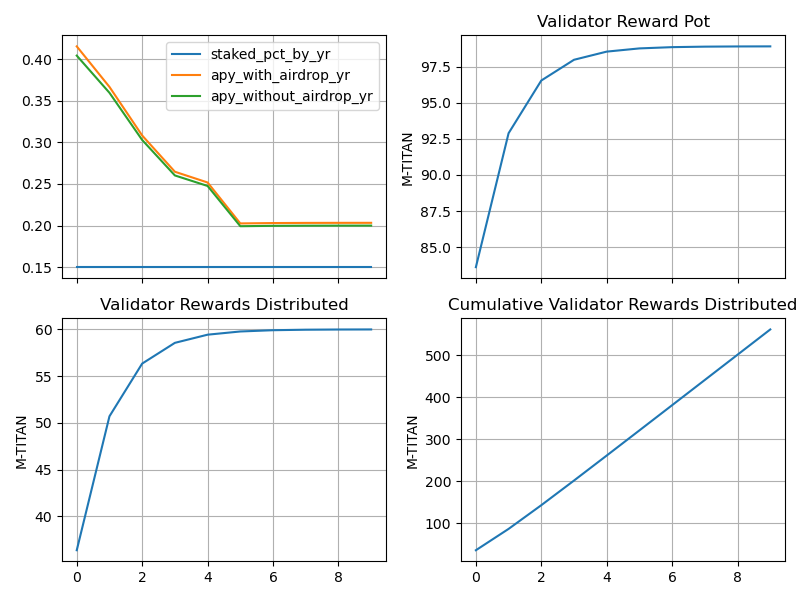

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8, 6))

axx = ax[0, 0]
axx.plot(results["staked_pct_by_yr"], label="staked_pct_by_yr")
axx.plot(results["apy_with_airdrop_yr"], label="apy_with_airdrop_yr")
axx.plot(results["apy_without_airdrop_yr"], label="apy_without_airdrop_yr")
axx.legend()
axx.grid()

axx = ax[0, 1]
axx.plot(results["validator_reward_pot_by_yr"]/1e6, label="validator_reward_pot")
axx.set_title("Validator Reward Pot")
axx.set_ylabel("M-TITAN")
# axx.legend()
axx.grid()

axx = ax[1, 0]
axx.plot(results["validator_rewards_distributed_by_yr"]/1e6, label="validator_rewards_distributed")
axx.set_title("Validator Rewards Distributed")
axx.set_ylabel("M-TITAN")
# axx.legend()
axx.grid()

axx = ax[1, 1]
axx.plot(results["validator_rewards_distributed_by_yr"].cumsum()/1e6, label="validator_rewards_distributed")
axx.set_title("Cumulative Validator Rewards Distributed")
axx.set_ylabel("M-TITAN")
# axx.legend()
axx.grid()


plt.tight_layout()